In [1]:
import bbknn, sys
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import umap

sys.path.append('data/')
from core import scAEspy

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.utils import shuffle
from matplotlib import pylab as plt

import os
from tqdm import tqdm


sc.settings.verbosity = 0

/home/badi/anaconda3/envs/scae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/badi/anaconda3/envs/scae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/badi/anaconda3/envs/scae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/badi/anaconda3/envs/scae/lib/python3.6/site-packages

In [2]:
def get_id_ctype(path, adata):
    adata.obs['neil_cell_type'] = ''
    with open(path, 'r') as f:
        f.readline()
        for line in f.readlines():
            cell, ctype = line.rstrip().split(',')
            cell = cell.split('_')[1] + '-1'
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'neil_cell_type'] = ctype
        
        
def get_cyc(path, adata):
    adata.obs['cycling'] = 'no'
    with open(path, 'r') as f:
        for line in f.readlines():
            cell, cyc = line.rstrip().split(',')
            cell = cell + '-1'
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'cycling'] = cyc
            
                
                
def get_adata(path, cpath, cyc_path):
    adata = sc.read_10x_mtx(path, cache=True)
    adata.var_names_make_unique()
    get_id_ctype(cpath, adata)
    get_cyc(cyc_path, adata)
    adata = adata[adata.obs.neil_cell_type == 'Hepatocytes']
    return adata

root_path = 'data/'
rna_path = root_path + 'rna_seq/'
lst_dirs = [dname for dname in os.listdir(rna_path) if os.path.isdir(rna_path+dname) and dname.startswith('2')]

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = rna_path + d + '/premrna_outs/filtered_feature_bc_matrix'
    sample = d.split('_')[-1]
    path_ctype = rna_path + d + '/premrna_outs/%s_broad_celltype.csv' % sample
    path_cyc = root_path + 'rnaseq_cycling.csv'
    if i == 0:
        adata = get_adata(path, path_ctype, path_cyc)
        adata.obs['donor'] = sample
    else:
        tmp = get_adata(path, path_ctype, path_cyc)
        tmp.obs['donor'] = sample
        adatas.append(tmp)

del tmp
adata = adata.concatenate(adatas)

cc_genes = pd.read_table('data/Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = list(cc_genes['S'].dropna())
g2m_genes = list(cc_genes['G2.M'].dropna())
s_genes = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes = adata.var_names[np.in1d(adata.var_names, g2m_genes)]
sc_genes = np.hstack((s_genes,g2m_genes))
se_genes = np.array([gene.rstrip() for gene in open('data/seurat_ccgenes.csv', 'r').readlines()])
cc_genes = np.unique(np.hstack((sc_genes, se_genes)))

msk = np.array([gene in cc_genes for gene in adata.var.index])

c_adata = adata[:,msk]
adata = adata[:,~msk]


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Populating the interactive namespace from numpy and matplotlib
 * Normalisation ...
 * Log-transformation ...
 * Highly Variable Genes using batches ...


/home/badi/anaconda3/envs/scae/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'shuffle', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
... storing 'neil_cell_type' as categorical
... storing 'cycling' as categorical
... storing 'donor' as categorical
... storing 'feature_types' as categorical


 	* Number of HVGs: 1000



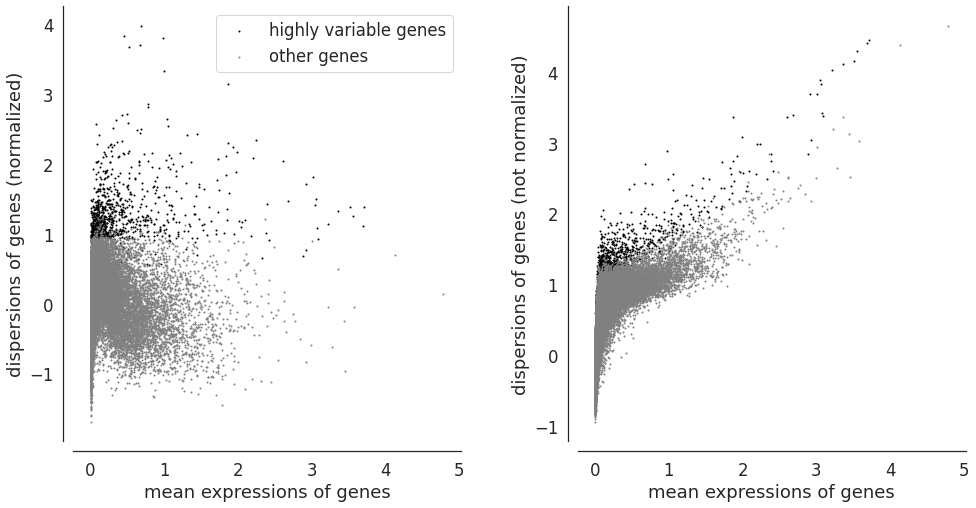

In [3]:
%pylab inline
print(" * Normalisation ...")
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1e4)

print(" * Log-transformation ...")
sc.pp.log1p(adata_norm)

adata_norm.raw = adata_norm

print(" * Highly Variable Genes using batches ...")
sc.pp.highly_variable_genes(adata_norm, n_top_genes=1000, batch_key="donor")

print(" \t* Number of HVGs: %d\n"%(adata_norm[:, adata_norm.var['highly_variable']].n_vars))

sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale=1.5)
sns.set_style("white")

sc.pl.highly_variable_genes(adata_norm, show=False)

sns.despine(offset=10, trim=False)


In [4]:
matrix = adata[:, adata_norm.var['highly_variable']].X

maxV  = int(np.max(matrix))
minV  = int(np.min(matrix))
expression = matrix[matrix>0]
meanV = int(np.round(np.mean(expression)))
medianV = int(np.round(np.median(expression,axis=1)))
print("* min value=%d, max value=%d, mean value=%d, median=%d"%(minV, maxV, meanV, medianV))

* min value=0, max value=2484, mean value=7, median=2


In [5]:
np.random.seed(42)
msk = np.arange(matrix.shape[0])
np.random.shuffle(msk)
data_shuffled = matrix[msk]

In [6]:
original_dim    = data_shuffled.shape[1]
hidden_layers   = [64]
latent_space    = 16
num_gaussians   = 4
learnable_prior = True
rec_loss        = "Poisson"
constrained     = True
activation      ='sigmoid'

alpha = 0
lambd = 2

In [7]:
GMMMDVAE = scAEspy(original_dim,
                   hidden_layers=hidden_layers,
                   latent_layer=latent_space,
                   learnable_prior=learnable_prior,
                   constrained=constrained,
                   num_gaussians=num_gaussians,
                   activation=activation,
                   rec_loss=rec_loss,
                   alpha=alpha,
                   lambd=lambd,
                   seed=42,
                   verbose=True)

GMMMDVAE.build()

 * Using 1 hidden layers [64]
 * Latent space: 16 dimensions
 * Using <function sigmoid at 0x7f696284ae18> as activation function
 * Setting seed to 42 for reproducibility


 * Epoch:  1
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 3.4063e-01, 1.6679e+01, 2.9573e-01, -1.2512e+03, 3.4063e-01, 1.6670e+01, 2.9478e-01, -1.2508e+03
	 tr_distinct clusters (3):  [1 2 3]
	 tr_distinct clusters %:  [0.04 0.38 0.59]
	 t_distinct clusters (3):  [1 2 3]
	 t_distinct clusters %:  [0.04 0.38 0.59]
 * Train:  -1233.847
 * Test:   -1233.469
 * -> A better loss value has been found


 * Epoch:  2
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 1.0887e+00, 4.0416e+01, 5.5507e-01, -2.0438e+03, 1.0887e+00, 4.0572e+01, 5.6169e-01, -2.0440e+03
	 tr_distinct clusters (1):  [3]
	 tr_distinct clusters %:  [1.]
	 t_distinct clusters (1):  [3]
	 t_distinct clusters %:  [1.]
 * Train:  -2001.718
 * Test:   -2001.728
 * -> A better loss value has been found


 * Epoch:  3
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 1.2884e+00, 2.4062

     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 4.3179e-01, 1.8379e+01, 7.4983e-02, -2.6810e+03, 4.3179e-01, 1.8334e+01, 7.4489e-02, -2.6808e+03
	 tr_distinct clusters (2):  [1 3]
	 tr_distinct clusters %:  [0.26 0.74]
	 t_distinct clusters (2):  [1 3]
	 t_distinct clusters %:  [0.26 0.74]
 * Train:  -2662.128
 * Test:   -2661.930
 * -> A better loss value has been found


 * Epoch:  22
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 4.2567e-01, 1.9004e+01, 7.2361e-02, -2.6937e+03, 4.2567e-01, 1.8968e+01, 7.1939e-02, -2.6937e+03
	 tr_distinct clusters (2):  [1 3]
	 tr_distinct clusters %:  [0.26 0.74]
	 t_distinct clusters (2):  [1 3]
	 t_distinct clusters %:  [0.26 0.74]
 * Train:  -2674.151
 * Test:   -2674.264
 * -> A better loss value has been found


 * Epoch:  23
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 4.2190e-01, 1.8992e+01, 6

     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 3.9341e-01, 1.9655e+01, 4.9293e-02, -2.7843e+03, 3.9341e-01, 1.9638e+01, 4.9242e-02, -2.7844e+03
	 tr_distinct clusters (4):  [0 1 2 3]
	 tr_distinct clusters %:  [0.   0.37 0.   0.63]
	 t_distinct clusters (4):  [0 1 2 3]
	 t_distinct clusters %:  [0.   0.37 0.   0.63]
 * Train:  -2764.169
 * Test:   -2764.319
 * -> A better loss value has been found


 * Epoch:  41
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      t_klz,      t_mmd,      t_rec
 4.1365e-01, 1.9321e+01, 4.7927e-02, -2.7884e+03, 4.1365e-01, 1.9302e+01, 4.7623e-02, -2.7881e+03
	 tr_distinct clusters (4):  [0 1 2 3]
	 tr_distinct clusters %:  [0.   0.32 0.   0.68]
	 t_distinct clusters (4):  [0 1 2 3]
	 t_distinct clusters %:  [0.   0.32 0.   0.68]
 * Train:  -2768.644
 * Test:   -2768.306
 * -> A better loss value has been found


 * Epoch:  42
     tr_kly,     tr_klz,     tr_mmd,     tr_rec,      t_kly,      

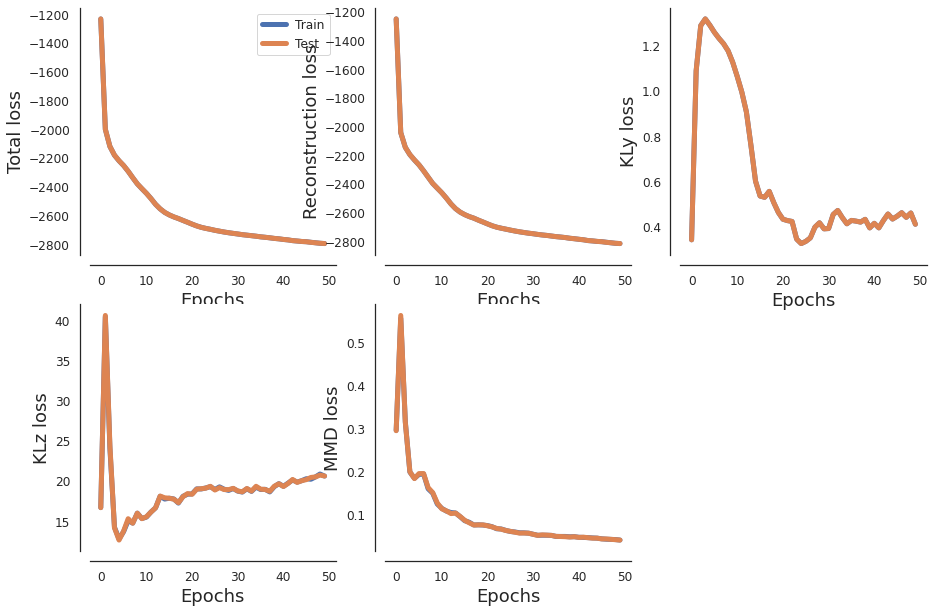

In [8]:
GMMMDVAE.train(data_shuffled.toarray(), data_shuffled.toarray(), epochs=50, batch_size=100)
GMMMDVAE.plotLosses()

In [14]:
reconstructed = GMMMDVAE.reconstructedRepresentation(matrix.toarray())

maxV  = int(np.max(matrix))
minV  = int(np.min(matrix))
expression = matrix[matrix>0]
meanV = int(np.round(np.mean(expression)))
medianV = int(np.round(np.median(expression, axis=1)))
print()
print("* Real cells: min value=%d, max value=%d, mean value=%d, median=%d"%(minV, maxV, meanV, medianV))


maxV  = int(np.max(reconstructed))
minV  = int(np.min(reconstructed))
expression = reconstructed[reconstructed>0]
meanV = int(np.round(np.mean(expression)))
medianV = int(np.round(np.median(expression)))
print("* Recon. cells: min value=%d, max value=%d, mean value=%d, median=%d"%(minV, maxV, meanV, medianV))


* Real cells: min value=0, max value=2484, mean value=7, median=2
* Recon. cells: min value=0, max value=1881, mean value=2, median=0


 * Fitting on all cells


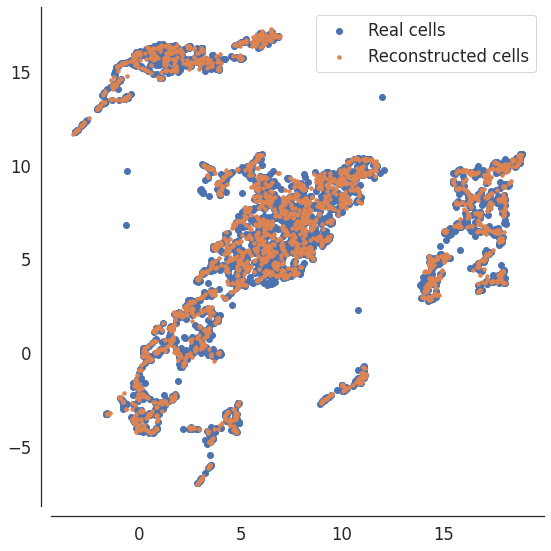

In [16]:


def computeUMAP(real=None, synth=None, fitAll=False, n_neighbors=5):
    
    ump  = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
            
    if (real is not None) and (synth is not None):
        
        if fitAll:
            print(" * Fitting on all cells")
            allCells = np.append(real, synth, axis=0)
            ump.fit(allCells)
        else:
            print(" * Fitting only on real cells")
            ump.fit(real)
        
        real = ump.transform(real)
        synt = ump.transform(synth)
        
        return real, synt
    
    elif real is not None:
        print(" * Only real cells")
        ump.fit(real)
        return ump.transform(real)
    
    elif synth is not None:
        print(" * Only synthetic cells")
        ump.fit(synth)
        return ump.transform(synth)
    

def plotCells(real=None, synth=None, axis=None,
              label1="Real", label2="Synthetic", title="",
              width=8, height=8):
    
    if axis is None:
        f, axis = plt.subplots(1,1,figsize=(width,height))
        sns.set(font_scale=1.5)
        sns.set_style("white")

    if real is not None:
        axis.scatter(real[:,0], real[:,1], s=36, label=label1)

    if synth is not None:
        axis.scatter(synth[:,0], synth[:,1], s=12, label=label2)
        
    axis.legend()
    axis.set_title(title)
    
    if axis is None:
        sns.despine(offset=10, trim=False)
        plt.tight_layout()
        plt.show()


real_cells, reconstructed_cells = computeUMAP(matrix.toarray(), reconstructed, fitAll=True)

f, axs = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale=1.5)
sns.set_style("white")

plotCells(real=real_cells,
          synth=reconstructed_cells,
          axis=axs,
          label1="Real cells",
          label2="Reconstructed cells")

sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show() 

In [18]:
latentRepresentation = GMMMDVAE.latentRepresentation(matrix.toarray())

 * Only real cells


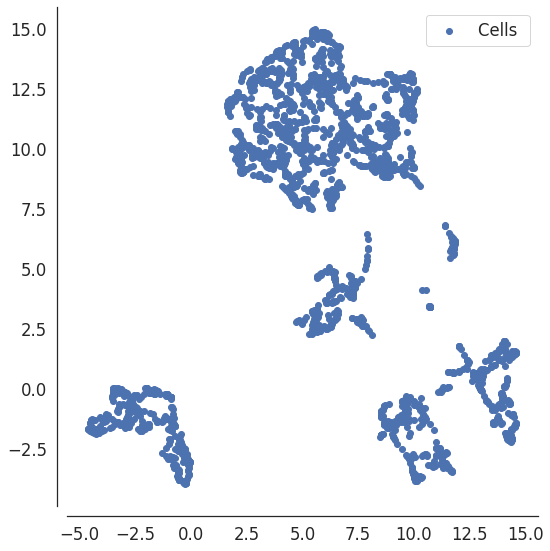

In [19]:


umapCellsLatent = computeUMAP(real=latentRepresentation)

f, axs = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale=1.5)
sns.set_style("white")

plotCells(real=umapCellsLatent, axis=axs, label1="Cells ")

sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show()



In [20]:
adata.obsm['X_pca'] = np.zeros((adata.shape[0], latent_space))

for idx,cell in enumerate(latentRepresentation):
    adata.obsm['X_pca'][idx] = cell

In [21]:
bbknn.bbknn(adata, n_pcs=latent_space)

In [24]:
sc.tl.umap(adata, random_state=10)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


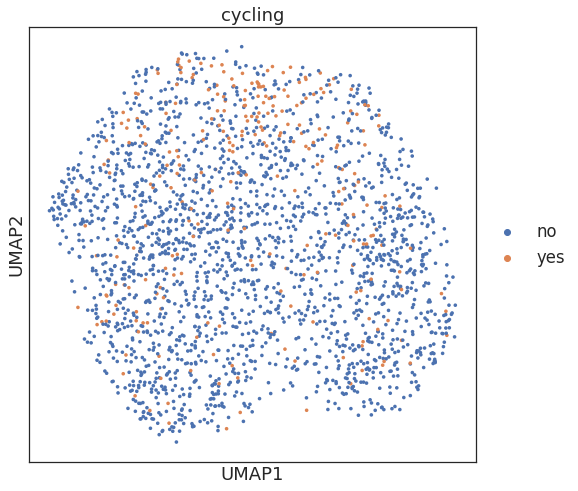

In [25]:
sc.pl.umap(adata, color=['cycling'])

In [27]:
adata

AnnData object with n_obs × n_vars = 2316 × 33255
    obs: 'neil_cell_type', 'cycling', 'donor', 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'neighbors', 'umap', 'cycling_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'